In [559]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%time
wb=pd.read_csv('data/array/GSE132203_Geo_Submission_GTPEpic.csv',nrows=1000000,usecols=[0]+list(range(1,1591,2)),index_col=0).round(3)

CPU times: user 3min 11s, sys: 14.6 s, total: 3min 26s
Wall time: 3min 27s


In [3]:
age=pd.read_table('https://ftp.ncbi.nlm.nih.gov/geo/series/GSE132nnn/GSE132203/matrix/GSE132203_series_matrix.txt.gz',skiprows=29+10,nrows=0,index_col=0).columns.str.strip('age: ').astype(float)

In [4]:
%%time 
wb_t=wb.T
wb_t['age']=age
wb_cor=wb_t.corrwith(wb_t['age']).drop('age').sort_values()

CPU times: user 3min 57s, sys: 1.49 s, total: 3min 59s
Wall time: 3min 59s


In [24]:
man=pd.read_table('../Blood-DNA-Methylation-Atlas/data/ref/EPIC.hg38.manifest.tsv',index_col='Probe_ID')[['CpG_chrm','CpG_beg']]
man=man.dropna().copy()
man['CpG_beg']=man['CpG_beg'].astype(int)
man.columns=[0,1]
man=man[man[0].isin('chr'+str(c) for c in range(1,23))].copy()
#man['cg']=man.index

In [31]:
man=man.merge(wb_cor.rename('cor'),left_index=True,right_index=True)
man['pos']=man[0].str[3:].astype(int)*10**9+man[1]
man=man.sort_values('pos')
man.shape
#man['bin']=man['cor']>0

(800192, 4)

In [ ]:
hmr=pd.read_table('/labs/mpsnyder/moqri/epi_deconv/data/arc/hmr/neo',header=None,index_col=3,usecols=[0,1,2,3])
hmr['b']=hmr[0].str[3:].astype(int)*10**9+hmr[1]
hmr['e']=hmr[0].str[3:].astype(int)*10**9+hmr[2]
hmr=hmr.sort_values('b')
%%time
l=[]
cur=0
for i,b in man.iterrows():
    if cur>=len(hmr):
        l.append(0)
    else: 
        pos=b['pos']
        cg=b.name
        b=hmr['b'].iloc[cur]
        e=hmr['e'].iloc[cur]        
        if pos<b:
            l.append(0)
        if pos>=b and pos<=e:
            l.append(cur)
        if pos>e:
            while (pos>hmr['e'].iloc[cur] and cur<len(hmr)-1):
                cur+=1
                b=hmr['b'].iloc[cur]
                e=hmr['e'].iloc[cur] 
            if pos>=b and pos<=e:
                l.append(cur)
            else:
                l.append(0)
man['hmr']=l
man['hmr_bin']=man['hmr'].clip(upper=1)

In [ ]:
cor450=pd.read_csv('data/res/cor450.csv',index_col=0)
man=man.merge(cor450,left_index=True, right_index=True,how='left')

In [140]:
cg=wb_cor[wb_cor>.0917].head(1).index[0]
pearsonr(wb_t[cg],wb_t['age'])

PearsonRResult(statistic=0.09170011703738634, pvalue=0.009683327216200192)

In [54]:
pv=.0917

In [174]:
#man=man[man['cor']>.07].copy()

In [242]:
%%time 
contp=[]
c=1000000
last=False
last_l=-1
last_pos=man[1].head(1).values[0]
for i,b in man[[1,'cor']].iterrows():
    if b[1]-last_pos>1000:
        c+=1
    if b['cor']>pv:
        if last==False:
            c+=1
        last=True  
        contp.append(c)
    else:
        contp.append(-1)
        last=False
    last_pos=b[1]

CPU times: user 53.6 s, sys: 296 ms, total: 53.9 s
Wall time: 54 s


In [256]:
%%time 
contn=[]
c=2000000
last=False
last_l=-1
last_pos=man[1].head(1).values[0]
for i,b in man[[1,'cor']].iterrows():
    if b[1]-last_pos>1000:
        c+=1
    if b['cor']<-pv:
        if last==False:
            c+=1
        last=True  
        contn.append(c)
    else:
        contn.append(-1)
        last=False
    last_pos=b[1]

CPU times: user 52.1 s, sys: 217 ms, total: 52.3 s
Wall time: 52.4 s


In [257]:
man['contp']=contp
man['contn']=contn

In [462]:
mgc=pd.DataFrame(man.groupby('contp')[0].count())
mgc['chr']=man.groupby('contp')[0].first()
mgc['b']=man.groupby('contp')[1].first()
mgc['e']=man.groupby('contp')[1].last()
mgc['cor']=man.groupby('contp')['cor'].mean()
mgc['cor450']=man.groupby('contp')['cor_450'].mean()
mgc['hmr']=man.groupby('contp')['hmr_bin'].mean()
topp=mgc[mgc[0]>=3].sort_values('cor',ascending=False)
topp.head(5)

,0,chr,b,e,cor,cor450,hmr
contp,,,,,,,
49023,3,chr2,105399281,105399309,0.717583,0.825327,1.000000
72766,9,chr3,51706605,51707456,0.539097,0.723285,0.888889
288581,4,chr15,72319783,72319879,0.526374,0.523217,1.000000
32067,3,chr1,228212515,228212926,0.515130,0.589686,1.000000
132279,3,chr6,27631361,27631395,0.497728,0.639231,1.000000


In [200]:
topp.to_csv('data/res/epicor_p.csv')

array([[<Axes: title={'center': 'cor450'}>]], dtype=object)

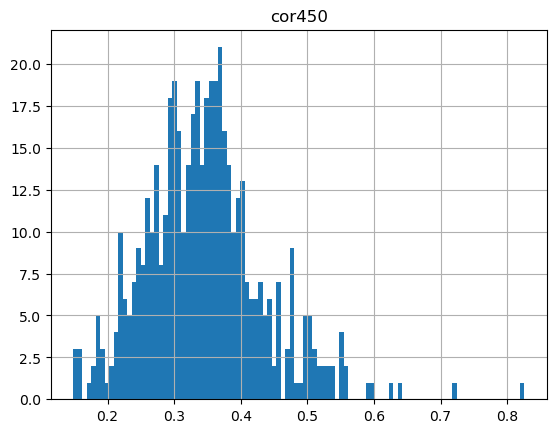

In [249]:
topl[['cor','cor450']].tail(500).hist('cor450',bins=100)

In [451]:
mgc=pd.DataFrame(man.groupby('contn')[0].count())
mgc['chr']=man.groupby('contn')[0].first()
mgc['b']=man.groupby('contn')[1].first()
mgc['e']=man.groupby('contn')[1].last()
mgc['cor']=man.groupby('contn')['cor'].mean()
mgc['hmr']=man.groupby('contp')['hmr_bin'].mean()
mgc['hmr']=mgc['hmr'].fillna(0)
mgc['cor450']=man.groupby('contn')['cor_450'].mean()
topn=mgc[mgc[0]>=3].sort_values('cor')
topn.head(5)

,0,chr,b,e,cor,hmr,cor450
contn,,,,,,,
364160,4,chr19,15419794,15420058,-0.492347,NaN,-0.510260
154263,6,chr6,110415218,110415849,-0.440743,NaN,-0.389990
6430,3,chr1,22642498,22642846,-0.432295,NaN,-0.198782
145942,3,chr6,33162210,33162256,-0.419197,NaN,-0.478346
96629,4,chr3,194270717,194271566,-0.413187,NaN,-0.564411


array([[<Axes: title={'center': 'cor450'}>]], dtype=object)

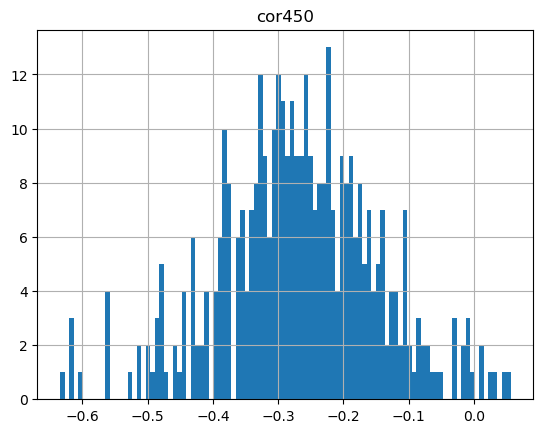

In [259]:
topn[['cor','cor450']].head(500).dropna().hist('cor450',bins=100)

In [260]:
topn.to_csv('data/res/epicor_n.csv')

<Axes: xlabel='dir', ylabel='0'>

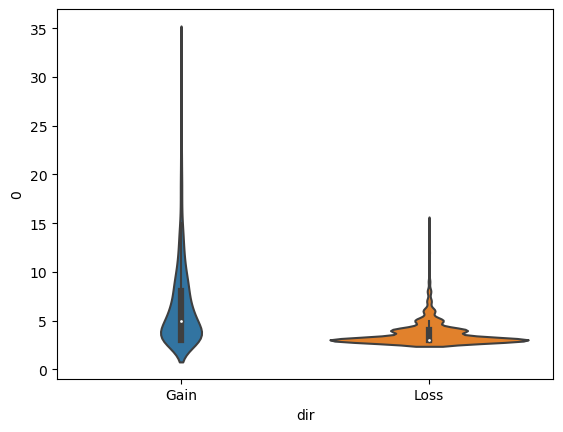

In [613]:
topp['dir']='Gain'
topn['dir']='Loss'
pl=pd.concat([topp.head(1000),topn.head(1000)])
sns.violinplot(data=pl[[0,'dir']],x='dir',y=0)

In [614]:
pl['rank']=pl['cor'].abs()
pl=pl.sort_values('rank',ascending=False).head(1000).copy()
pl=pl.drop('rank',axis=1)
pl.index=range(1,1001)

In [615]:
pl['hmr']=(pl['hmr']>0)

In [616]:
pg=pl.groupby(['dir','hmr'])['cor'].count()

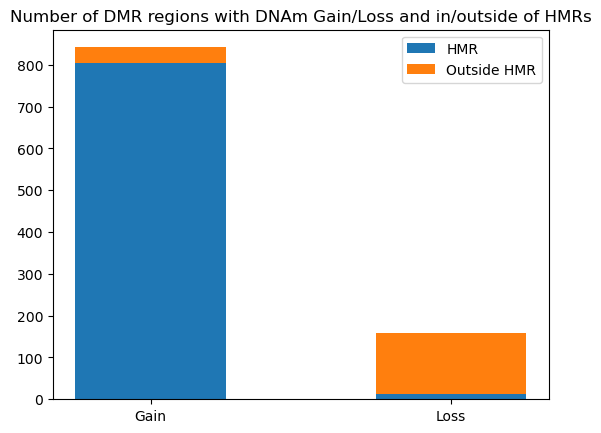

In [617]:
direc = (
    "Gain",
    "Loss",
)
counts = {
    "HMR": np.array([pg.loc[('Gain', True)],pg.loc[('Loss', True)]]),
    "Outside HMR": np.array([pg.loc[('Gain', False)],pg.loc[('Loss', False)]]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

for boolean, c in counts.items():
    p = ax.bar(direc, c, width, label=boolean, bottom=bottom)
    bottom += c

ax.set_title("Number of DMR regions with DNAm Gain/Loss and in/outside of HMRs")
ax.legend(loc="upper right")

plt.show()

In [ ]:
%%time
pro=pd.read_table('data/ref/promoters.txt',header=None,index_col=3)[[0,6,5]]
dic={}
for c in range(1,23):
    dic['chr'+str(c)]=pro[pro[0]=='chr'+str(c)]
g=[]
gd=[]
for i,b in pl[['chr','b','e']].iterrows():
    inp=0
    clos=999999
    for j,r in dic[b['chr']][[6,5]].iterrows():
        if r[6]>=b['b'] and r[6]<=b['e']:
            g.append(r.name)
            gd.append(0)
            inp=1
            break
        else:
            if r[6]<b['b']:
                d=b['b']-r[6]
            if r[6]>b['e']:
                d=r[6]-b['b']
        if d<clos:
            clos=d
            clos_g=r.name
    if inp==0:
        g.append(clos_g)
        gd.append(clos)

In [618]:
pl['g']=g
pl['gd']=gd

In [619]:
pl['g']=pl['g'].str.split('_').str[0]

In [620]:
pl.columns=['Number of CpGs','Chr','DMR Start','DMR End','Corr (Epic)','Corr (450k)', 
            'HMR','Gain or Loss','Gene','Distance to TSS']

In [621]:
pl[['Gene','Distance to TSS','Number of CpGs','Chr','DMR Start','DMR End','Corr (Epic)','Corr (450k)', 
            'HMR','Gain or Loss']].round(2).to_csv('data/res/genes.csv')